<a href="https://colab.research.google.com/github/Dailehit/models/blob/main/kaggle_fin_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

university homework on predicting credit default as part of kaggle competition


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re


gc.enable()

# EDA

## Bureau balance

In [ ]:
bureau_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv')
print('bureau balance shape : ',bureau_balance.shape)

bureau balance shape :  (27299925, 3)


In [ ]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Text(0.5, 0, 'Статус баланса')

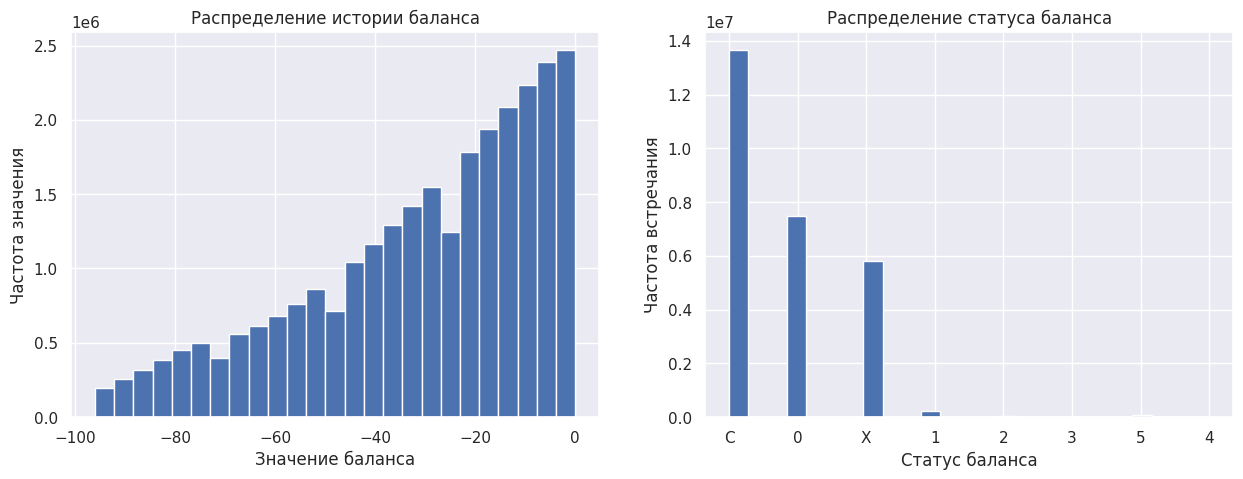

In [ ]:
bureau_balance['STATUS'].value_counts()

_, ax = plt.subplots(1,2,figsize = (15,5))

ax[0].hist(bureau_balance['MONTHS_BALANCE'], bins=25)
ax[0].set_title("Распределение истории баланса")
ax[0].set_ylabel("Частота значения")
ax[0].set_xlabel("Значение баланса")

ax[1].hist(bureau_balance['STATUS'], bins=25)
ax[1].set_title("Распределение статуса баланса")
ax[1].set_ylabel("Частота встречания")
ax[1].set_xlabel("Статус баланса")

In [ ]:
bureau_balance = pd.concat([bureau_balance, pd.get_dummies(buro_bal.STATUS, prefix='buro_bal_status')], axis=1).drop('STATUS', axis=1)


In [ ]:
buro_counts = bureau_balance[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
bureau_balance['buro_count'] = bureau_balance['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,buro_bal_status_0,buro_bal_status_1,buro_bal_status_2,buro_bal_status_3,buro_bal_status_4,buro_bal_status_5,buro_bal_status_C,buro_bal_status_X,buro_count
0,5715448,0,False,False,False,False,False,False,True,False,27
1,5715448,-1,False,False,False,False,False,False,True,False,27
2,5715448,-2,False,False,False,False,False,False,True,False,27
3,5715448,-3,False,False,False,False,False,False,True,False,27
4,5715448,-4,False,False,False,False,False,False,True,False,27


In [ ]:
avg_bureau_bal = bureau_balance.groupby('SK_ID_BUREAU').mean()
avg_bureau_bal.columns = ['avg_buro_' + f_ for f_ in avg_buro_bal.columns]
avg_bureau_bal.head()

,avg_buro_avg_buro_MONTHS_BALANCE,avg_buro_avg_buro_buro_bal_status_0,avg_buro_avg_buro_buro_bal_status_1,avg_buro_avg_buro_buro_bal_status_2,avg_buro_avg_buro_buro_bal_status_3,avg_buro_avg_buro_buro_bal_status_4,avg_buro_avg_buro_buro_bal_status_5,avg_buro_avg_buro_buro_bal_status_C,avg_buro_avg_buro_buro_bal_status_X,avg_buro_avg_buro_buro_count
SK_ID_BUREAU,,,,,,,,,,
5001709,-48.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.886598,0.113402,97.0
5001710,-41.0,0.060241,0.0,0.0,0.0,0.0,0.0,0.578313,0.361446,83.0
5001711,-1.5,0.750000,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,4.0
5001712,-9.0,0.526316,0.0,0.0,0.0,0.0,0.0,0.473684,0.000000,19.0
5001713,-10.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,22.0


## Bureau

In [ ]:
bureau = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')

In [ ]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:
bureau.dtypes

SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object

In [ ]:
print('Cat encoding')
bureau_ca = pd.get_dummies(bureau.CREDIT_ACTIVE, prefix='ca_')
bureau_cc = pd.get_dummies(bureau.CREDIT_CURRENCY, prefix='cc_')
bureau_ct = pd.get_dummies(bureau.CREDIT_TYPE, prefix='ct_')


Cat encoding


In [ ]:
bureau_full = pd.concat([bureau, bureau_ca, bureau_cc, bureau_ct], axis=1)
bureau_full.drop(['CREDIT_ACTIVE','CREDIT_CURRENCY','CREDIT_TYPE'], inplace = True, axis = 1)

In [ ]:
print('Merge avg')
bureau_full = bureau_full.merge(right=avg_bureau_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))

Merge avg


In [ ]:
print('Averaging bureau')
avg_bureau_full = bureau_full.groupby('SK_ID_CURR').mean()
# print(avg_buro.head())

Averaging bureau


## Previous application

In [ ]:
prev_app = pd.read_csv('/kaggle/input/home-credit-default-risk/previous_application.csv')

In [ ]:
cat_features = [
    col for col in prev_app.columns if prev_app[col].dtype == 'object'
]
cat_features

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

In [ ]:
print('Encoding cat features')
prev_dum = pd.DataFrame()
for col in cat_features:
    prev_dum = pd.concat([prev_dum, pd.get_dummies(prev_app[col], prefix=col).astype(np.uint8)], axis=1)

prev_app = pd.concat([prev_app, prev_dum], axis=1)
prev_app.drop(cat_features, inplace = True, axis = 1)

Encoding cat features


In [ ]:
print('Averaging prev app')
avg_prev_app = prev_app.groupby('SK_ID_CURR').mean()
avg_prev_app.head()

Averaging prev app


,SK_ID_PREV,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1.369693e+06,3951.000,24835.50,23787.00,2520.0,24835.5,13.000000,1.0,0.104326,NaN,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
100002,1.038818e+06,9251.775,179055.00,179055.00,0.0,179055.0,9.000000,1.0,0.000000,NaN,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0
100003,2.281150e+06,56553.990,435436.50,484191.00,3442.5,435436.5,14.666667,1.0,0.050030,NaN,...,0.333333,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
100004,1.564014e+06,5357.250,24282.00,20106.00,4860.0,24282.0,5.000000,1.0,0.212008,NaN,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
100005,2.176837e+06,4813.200,22308.75,20076.75,4464.0,44617.5,10.500000,1.0,0.108964,NaN,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.5,0.0,0.0,0.0


## Pos and CC balance

In [ ]:
print('POS_CASH')
pos = pd.read_csv('/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv')

print('Cat encoding')
pos = pd.concat([pos, pd.get_dummies(pos['NAME_CONTRACT_STATUS'])], axis=1)
pos.drop('NAME_CONTRACT_STATUS',inplace = True, axis = 1)

print('averages')
avg_pos = pos.groupby('SK_ID_CURR').mean()

del pos, nb_prevs
gc.collect()

print('CC balance')
cc_bal = pd.read_csv('/kaggle/input/home-credit-default-risk/credit_card_balance.csv')

print('Cat encoding')
cc_bal = pd.concat([cc_bal, pd.get_dummies(cc_bal['NAME_CONTRACT_STATUS'], prefix='cc_bal_status_')], axis=1)
cc_bal.drop('NAME_CONTRACT_STATUS',inplace = True, axis = 1)

print('average')
avg_cc_bal = cc_bal.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]

POS_CASH
Cat encoding
averages
CC balance
Cat encoding
average


# Train and test

In [ ]:
train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
test = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')
print(train.shape, test.shape)

(307511, 122) (48744, 121)


In [ ]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train.isna().sum().sort_values(ascending=False)

COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_AVG     213514
                             ...  
NAME_HOUSING_TYPE                0
NAME_FAMILY_STATUS               0
NAME_EDUCATION_TYPE              0
NAME_INCOME_TYPE                 0
SK_ID_CURR                       0
Length: 122, dtype: int64

In [ ]:
len(train.columns)

122

In [ ]:
threshold = 0.8 * len(train)

# Drop columns with more than the specified threshold of missing values
train = train.dropna(axis=1, thresh=threshold)
feat = list(train.columns)
feat.remove('TARGET')
test = test[feat]

In [ ]:
len(train.columns)

72

In [ ]:
cat_feats = [
    col for col in train.columns if train[col].dtype == 'object'
]
print(cat_feats)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']


In [ ]:
num_feats = [
    col for col in train.columns if train[col].dtype != 'object'
]
print(num_feats)

['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DO

In [ ]:
len(num_feats)

60

<Figure size 1600x1200 with 0 Axes>

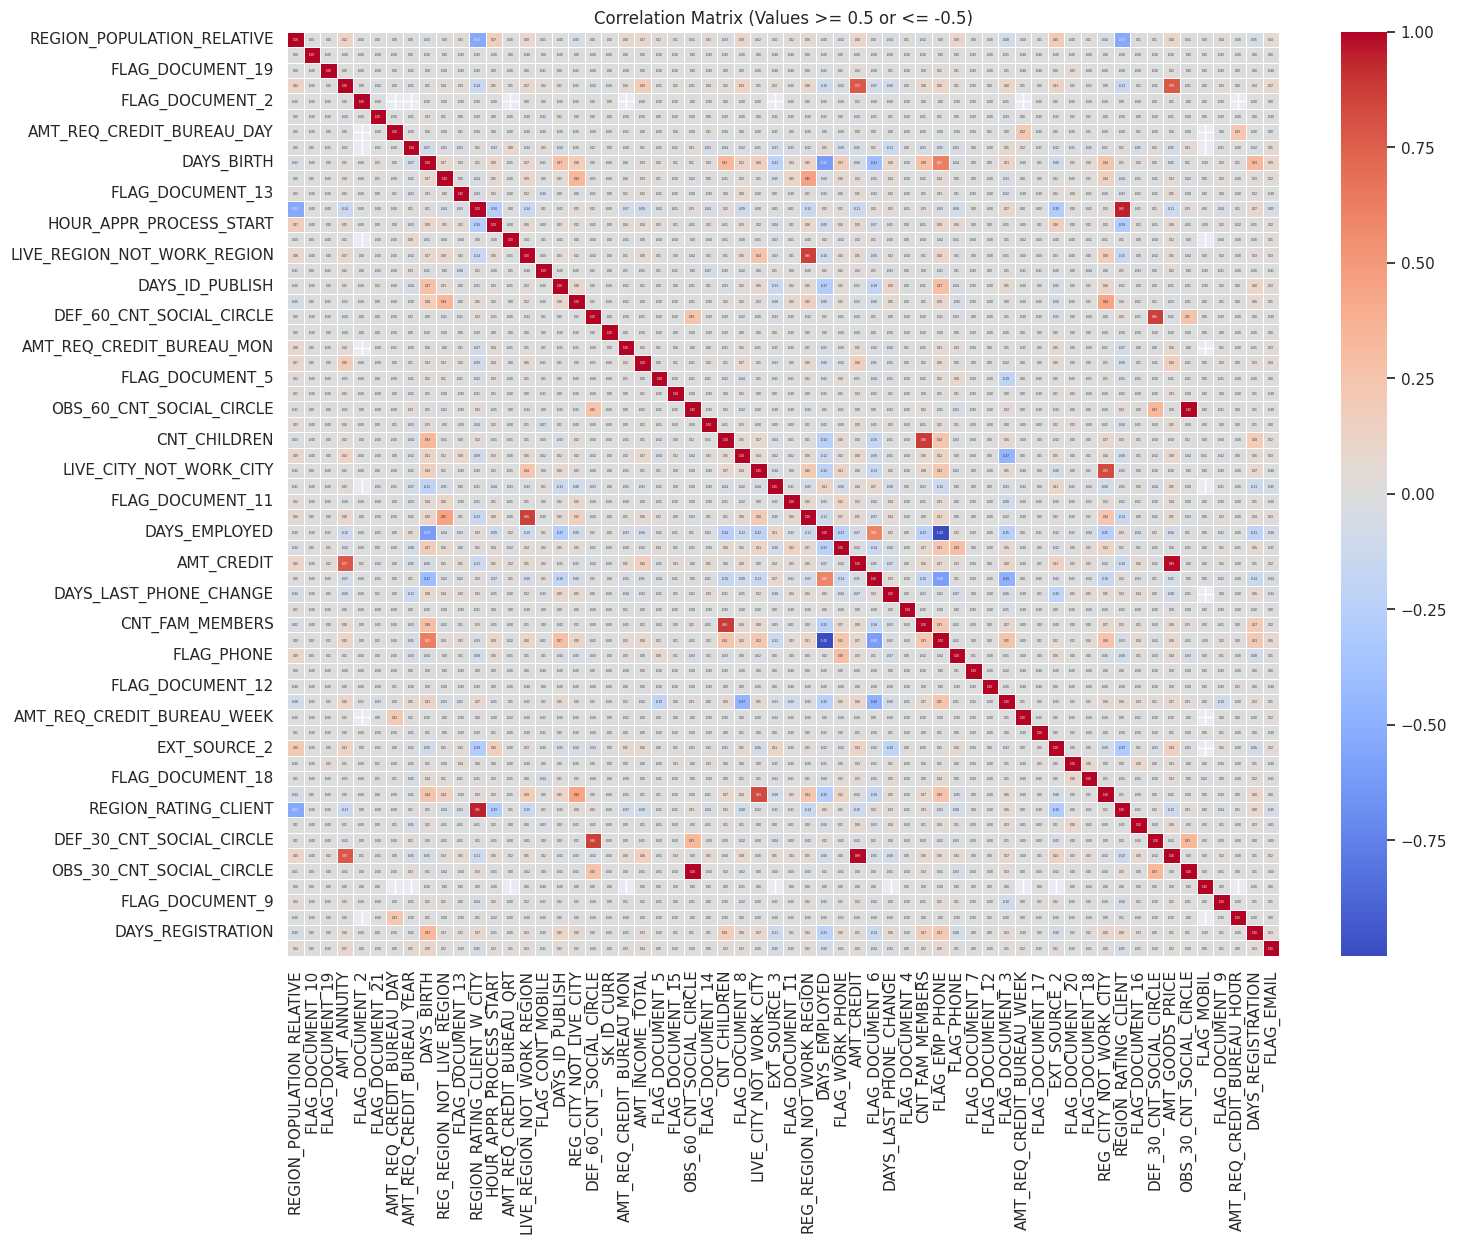

In [ ]:
# Calculate the correlation matrix
correlation_matrix = train[num_feats].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(16, 12))

highly_correlated_columns = set()
for col in correlation_matrix.columns:
    correlated_cols = correlation_matrix[(correlation_matrix[col] > 0.5) | (correlation_matrix[col] < -0.5)].index.tolist()
    highly_correlated_columns.update(correlated_cols)

# Filter the correlation matrix and create a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix.loc[list(highly_correlated_columns),list(highly_correlated_columns)], cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5,
            annot_kws={"size": 2})  # Adjust the "size" parameter for smaller text
plt.title('Correlation Matrix (Values >= 0.5 or <= -0.5)')
plt.show()


In [ ]:
# highly_correlated_columns = set()
# for col in correlation_matrix.columns:
#     correlated_cols = correlation_matrix[(correlation_matrix[col] > 0.9) | (correlation_matrix[col] < -0.9)].index.tolist()
#     highly_correlated_columns.update(correlated_cols)

# # Drop the highly correlated columns from the training dataset
# train = train.drop(columns=highly_correlated_columns)

# # Print the resulting training dataset
# print(ltrain.columns))

11


In [ ]:
cat_feats = [
    col for col in train.columns if train[col].dtype == 'object'
]
print(cat_feats)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']


In [ ]:
print(len(cat_feats))

11


In [ ]:
train[list(cat_feats)]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,WEDNESDAY,Business Entity Type 3
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,MONDAY,School
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,MONDAY,Government
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,WEDNESDAY,Business Entity Type 3
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,THURSDAY,Religion
...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,THURSDAY,Services
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,MONDAY,XNA
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,THURSDAY,School
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,WEDNESDAY,Business Entity Type 1


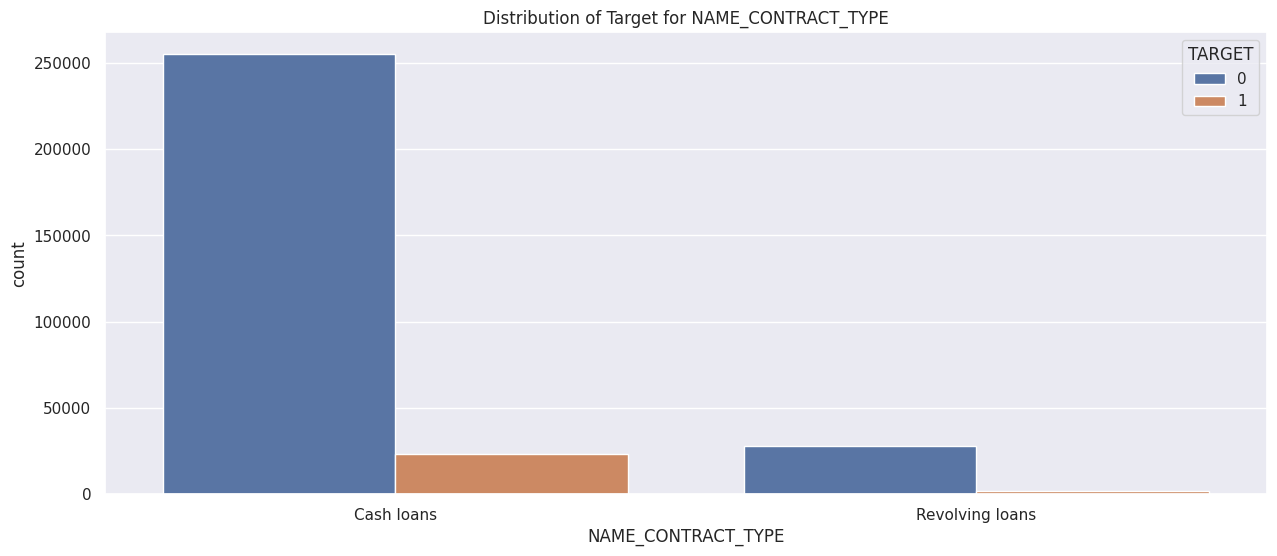

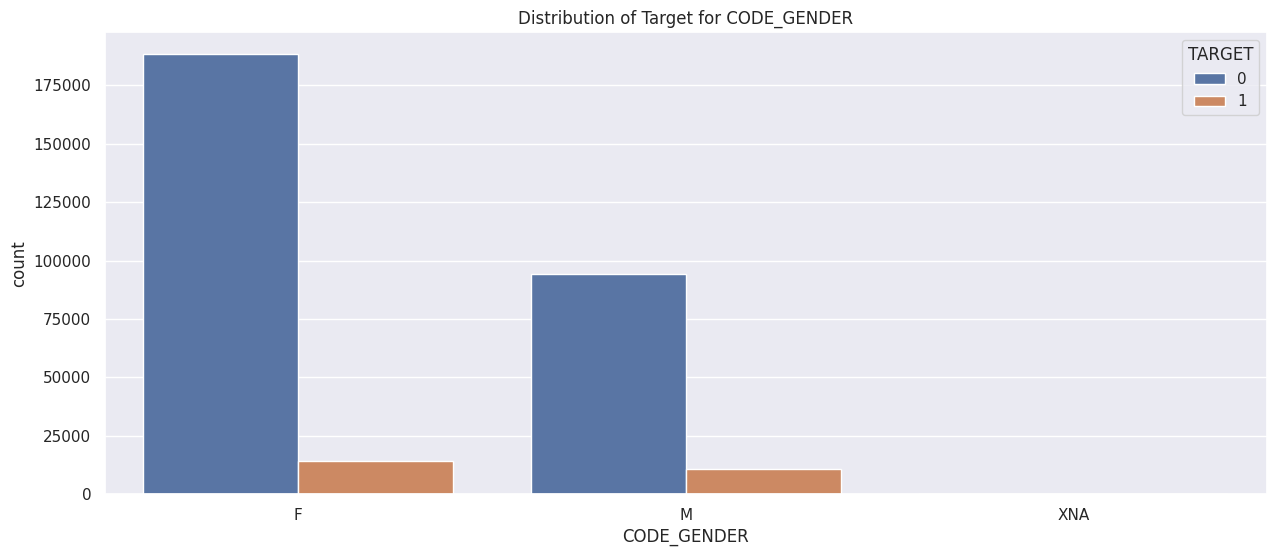

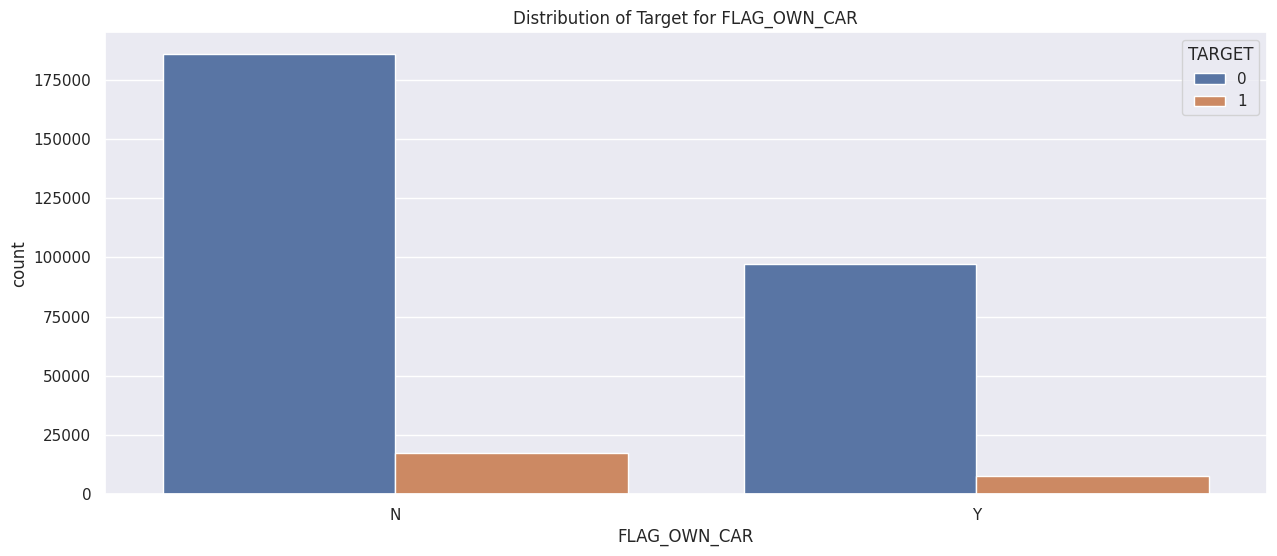

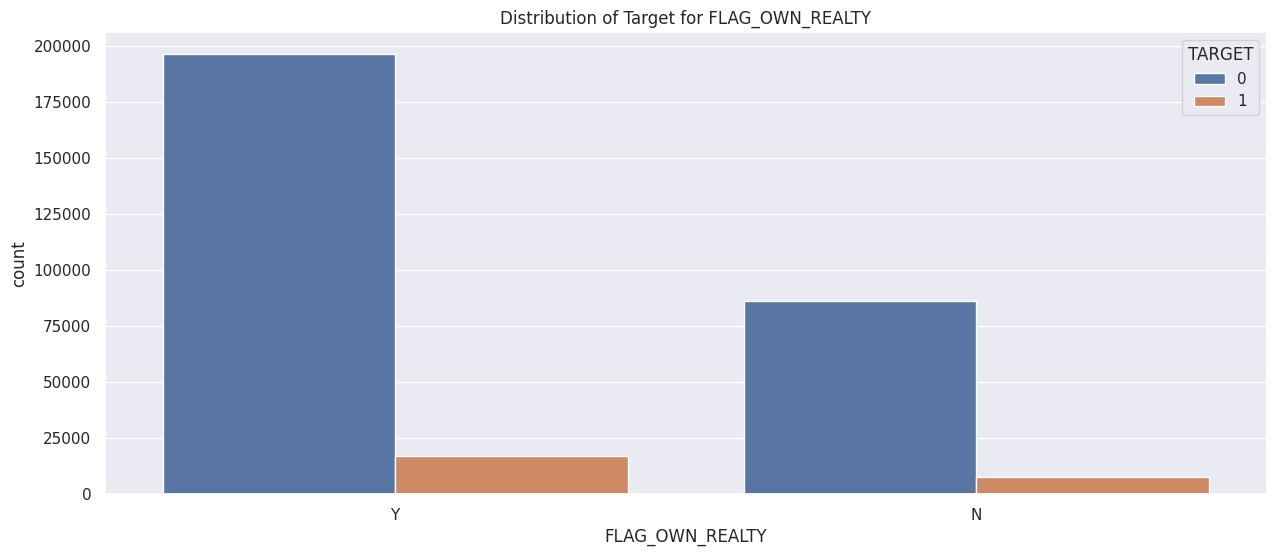

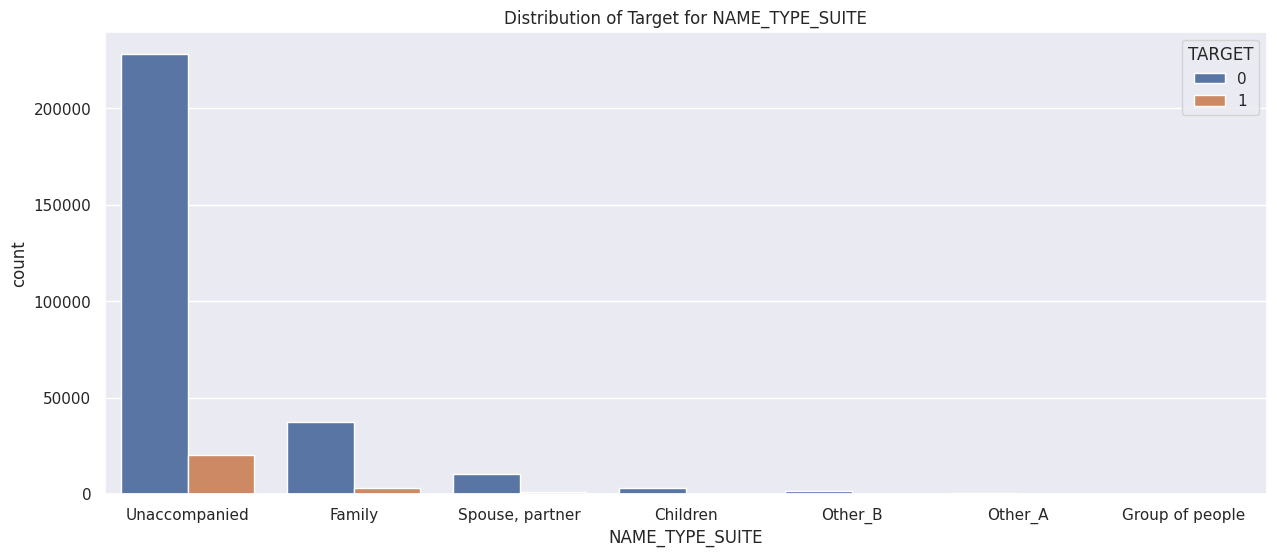

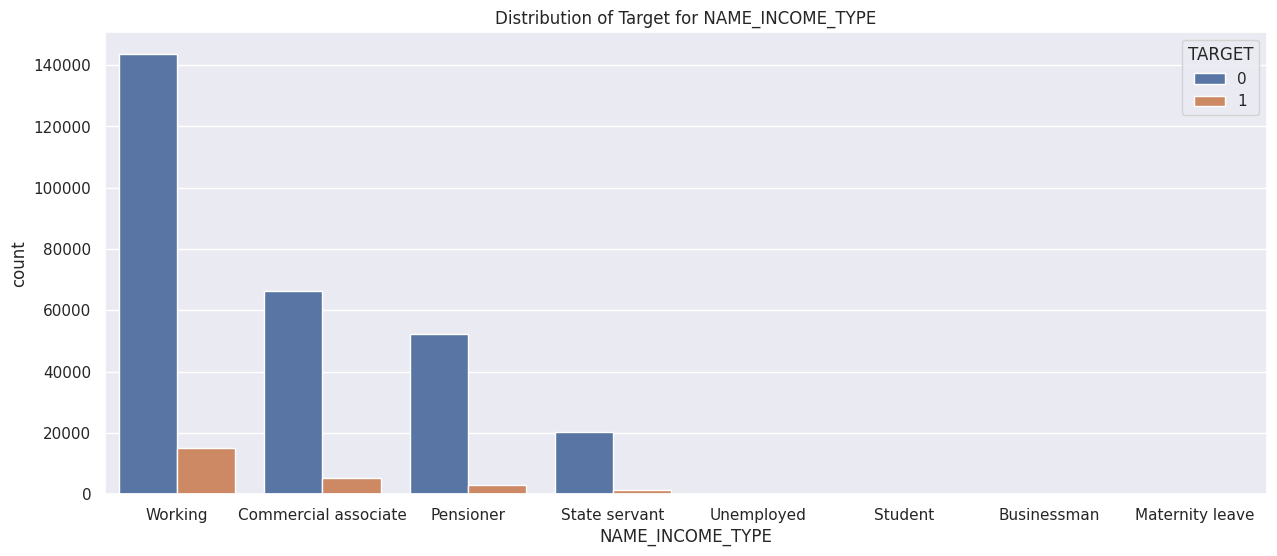

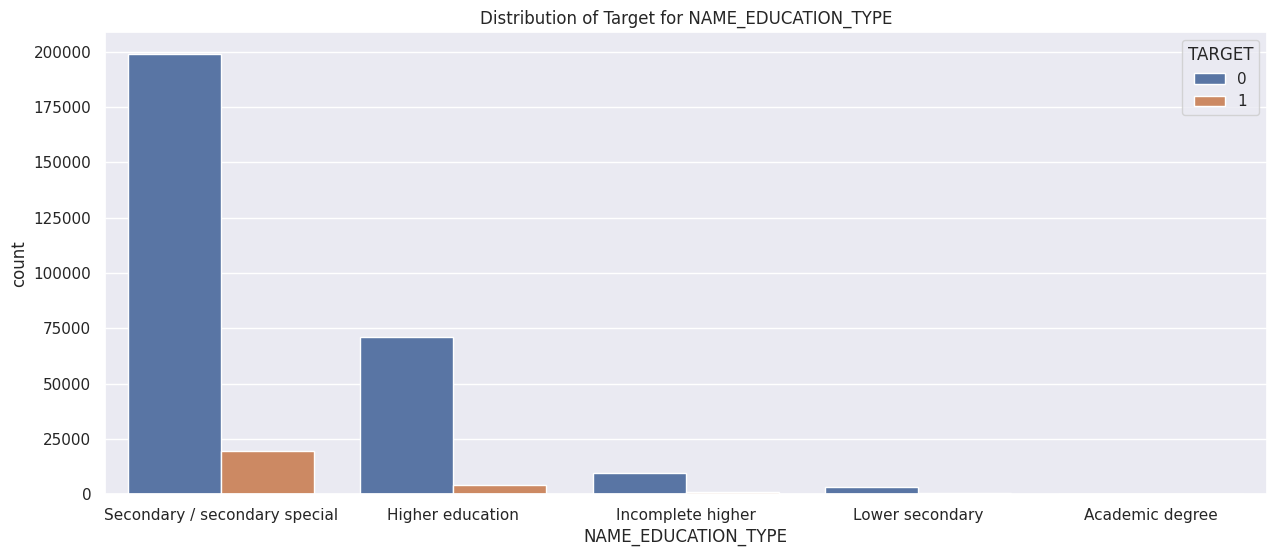

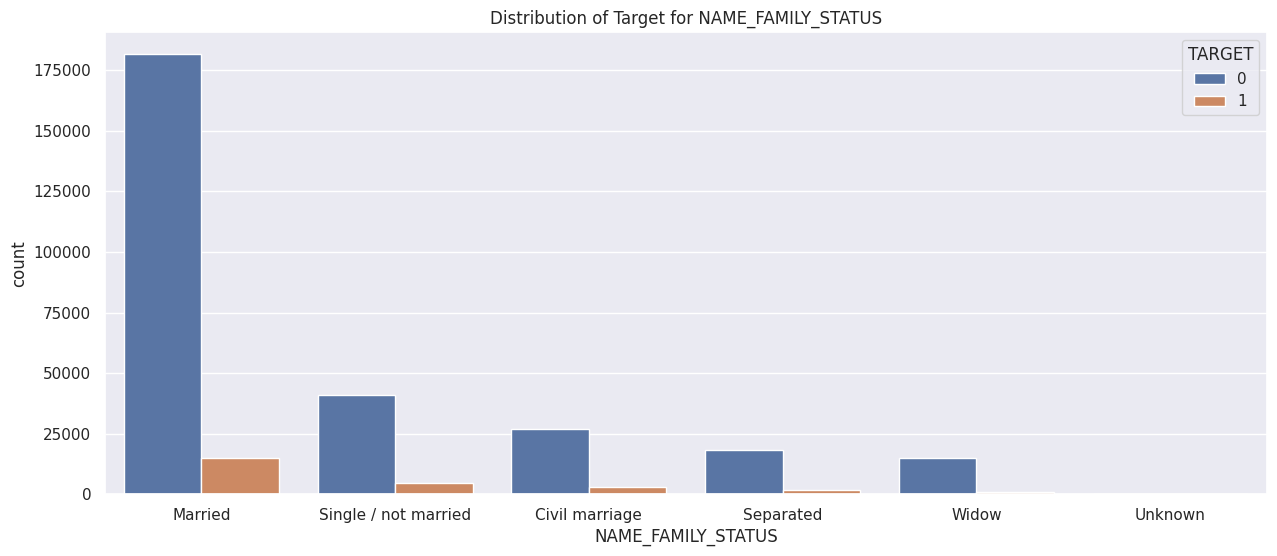

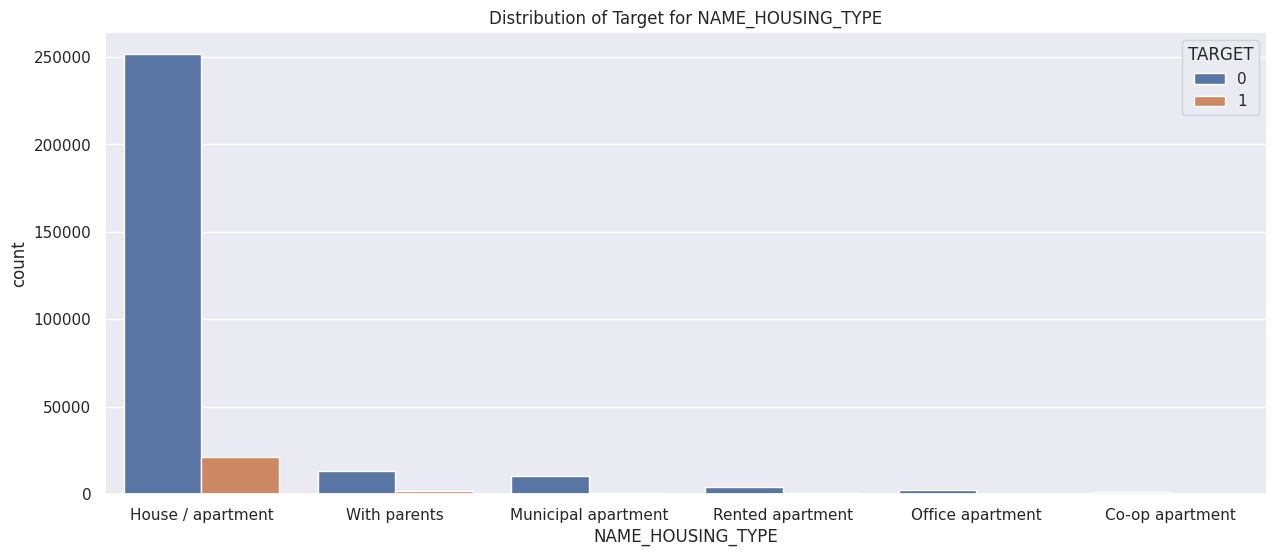

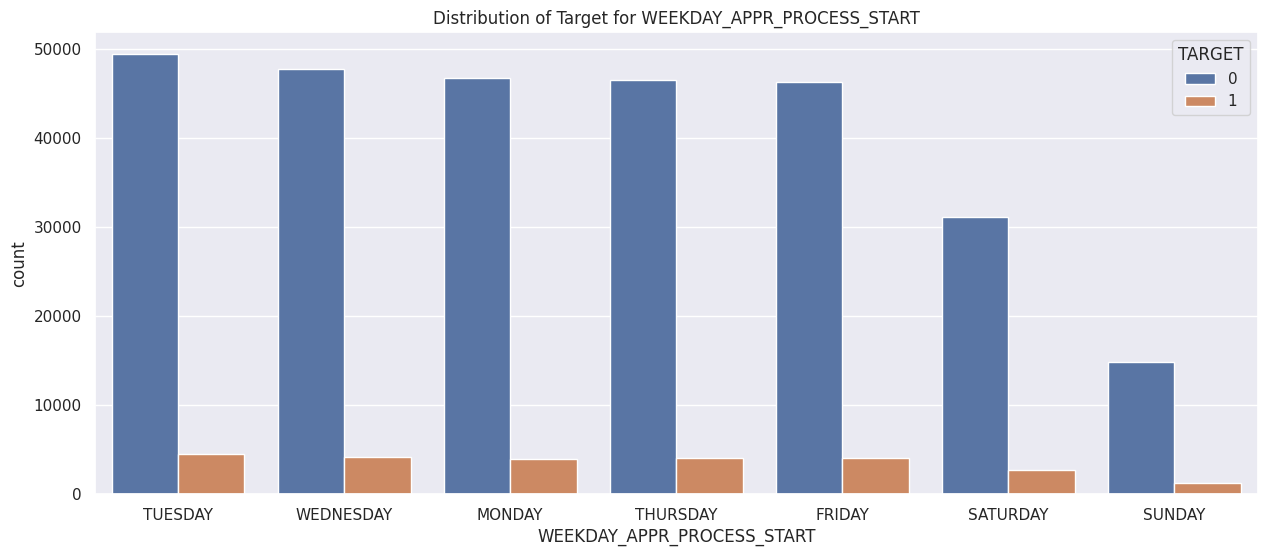

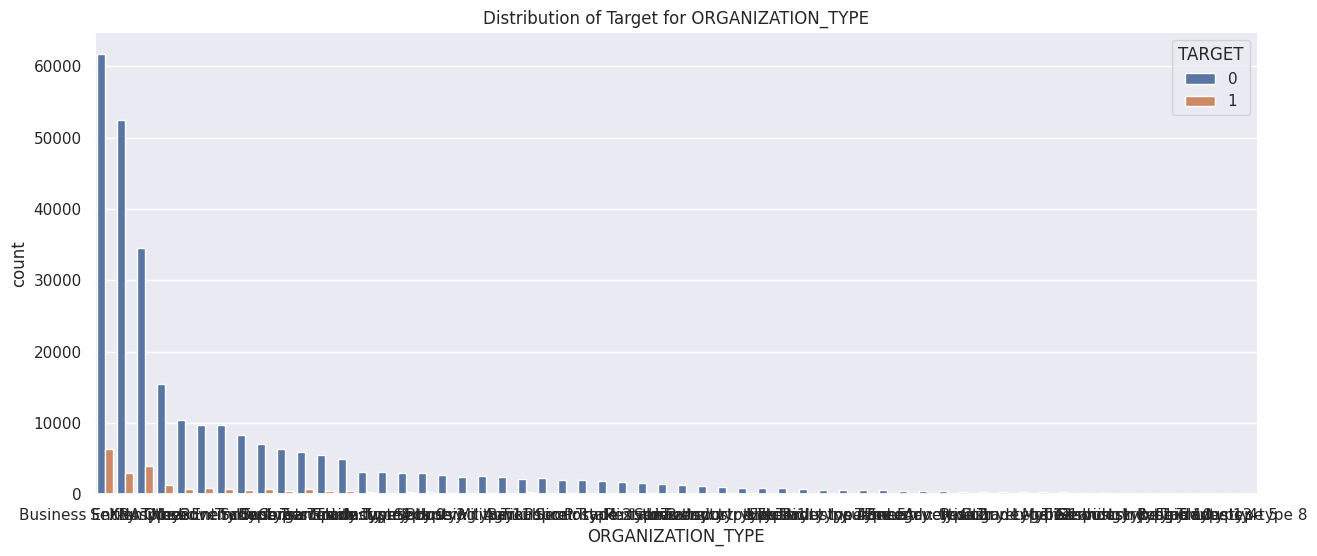

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
cat_feats_v = list(cat_feats)
cat_feats_v.append('TARGET')
df_vis = train[cat_feats_v]

# Iterate over each categorical feature
for cat_feature in df_vis.select_dtypes(include='object').columns:
    plt.figure(figsize=(15, 6))

    # Create a bar plot for the distribution of the target variable for each class in the categorical feature
    sns.countplot(x=cat_feature, hue='TARGET', data=df_vis, order=df_vis[cat_feature].value_counts().index)
    plt.title(f'Distribution of Target for {cat_feature}')
    plt.show()


## Feature encoding

In [ ]:
for col in cat_feats:
    train[col], indexer = pd.factorize(train[col])
    test[col] = indexer.get_indexer(test[col])

In [ ]:
train = train.merge(right=avg_bureau_full.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_bureau_full.reset_index(), how='left', on='SK_ID_CURR')

train = train.merge(right=avg_prev_app.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_prev_app.reset_index(), how='left', on='SK_ID_CURR')

train = train.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')

train = train.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

In [ ]:
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train = train.loc[:,~train.columns.duplicated()].copy()
test = test.loc[:,~test.columns.duplicated()].copy()


Text(0, 0.5, 'Quantity')

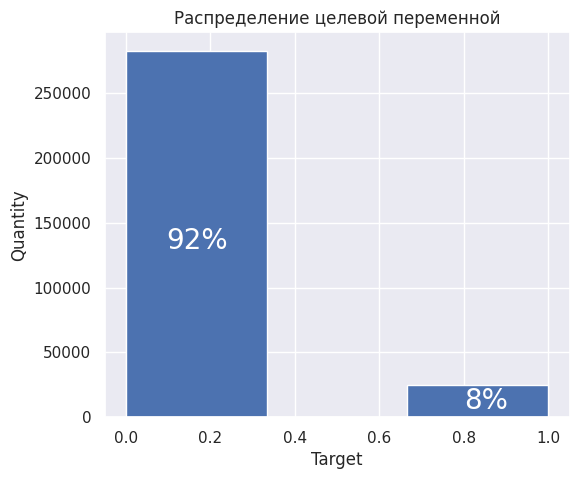

In [ ]:
count_0 = (y == 0).sum() * 100 / y.shape[0]
count_1 = (y == 1).sum() * 100 / y.shape[0]
plt.figure(figsize=(6,5))
plt.text(0.095,130000, str(round(count_0))+'%', color = 'w', fontsize=20)
plt.text(0.8,6500, str(round(count_1))+'%', color = 'w', fontsize=20)
plt.hist(y, bins=3)
plt.title('Распределение целевой переменной')
plt.xlabel('Target')
plt.ylabel('Quantity')

# Modeling

In [ ]:
y = train['TARGET']
del train['TARGET']

In [ ]:
from lightgbm import LGBMClassifier
import gc

gc.enable()

folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test.shape[0])

feature_importance_df = pd.DataFrame()

feats = list(set([col for col in train.columns if col not in ['SK_ID_CURR']]))

In [ ]:
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train)):
    trn_x, trn_y = train[feats].iloc[trn_idx], y.iloc[trn_idx]

    val_x, val_y = train[feats].iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=1000,
        learning_rate=1e-2,
        num_leaves = 18,
        colsample_bytree=0.8,
        subsample=0.8,
        max_depth=5,
        reg_alpha=1e-1,
        reg_lambda=1e-1,
        min_split_gain=1e-2,
        min_child_weight=120,
        silent=-1,
        verbose=-1,
    )

    clf.fit(trn_x, trn_y,
            eval_set= [(trn_x, trn_y), (val_x, val_y)],
            eval_metric='auc', verbose=100, early_stopping_rounds=350  #30
           )

    oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()

/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[100]	training's auc: 0.740855	training's binary_logloss: 0.258506	valid_1's auc: 0.734628	valid_1's binary_logloss: 0.258407
[200]	training's auc: 0.754442	training's binary_logloss: 0.25102	valid_1's auc: 0.746849	valid_1's binary_logloss: 0.251671
[300]	training's auc: 0.766561	training's binary_logloss: 0.246555	valid_1's auc: 0.757036	valid_1's binary_logloss: 0.247988
[400]	training's auc: 0.774409	training's binary_logloss: 0.243531	valid_1's auc: 0.762904	valid_1's binary_logloss: 0.245742
[500]	training's auc: 0.780002	training's binary_logloss: 0.241307	valid_1's auc: 0.766834	valid_1's binary_logloss: 0.244186
[600]	training's auc: 0.784427	training's binary_logloss: 0.239537	valid_1's auc: 0.769866	valid_1's binary_logloss: 0.242982
[700]	training's auc: 0.787948	training's binary_logloss: 0.238106	valid_1's auc: 0.772065	valid_1's binary_logloss: 0.24207
[800]	training's auc: 0.79087	training's binary_logloss: 0.236907	valid_1's auc: 0.773755	valid_1's binary_logloss: 0.24

/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[100]	training's auc: 0.74206	training's binary_logloss: 0.258539	valid_1's auc: 0.737706	valid_1's binary_logloss: 0.258185
[200]	training's auc: 0.754581	training's binary_logloss: 0.25101	valid_1's auc: 0.747777	valid_1's binary_logloss: 0.251564
[300]	training's auc: 0.766527	training's binary_logloss: 0.246536	valid_1's auc: 0.75707	valid_1's binary_logloss: 0.247927
[400]	training's auc: 0.774441	training's binary_logloss: 0.243483	valid_1's auc: 0.763132	valid_1's binary_logloss: 0.245582
[500]	training's auc: 0.780092	training's binary_logloss: 0.241236	valid_1's auc: 0.767195	valid_1's binary_logloss: 0.243975
[600]	training's auc: 0.784577	training's binary_logloss: 0.239452	valid_1's auc: 0.77005	valid_1's binary_logloss: 0.242825
[700]	training's auc: 0.78809	training's binary_logloss: 0.238046	valid_1's auc: 0.771918	valid_1's binary_logloss: 0.24205
[800]	training's auc: 0.790957	training's binary_logloss: 0.236866	valid_1's auc: 0.7734	valid_1's binary_logloss: 0.241444


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[100]	training's auc: 0.741313	training's binary_logloss: 0.257241	valid_1's auc: 0.734396	valid_1's binary_logloss: 0.263332
[200]	training's auc: 0.754964	training's binary_logloss: 0.249771	valid_1's auc: 0.745895	valid_1's binary_logloss: 0.256537
[300]	training's auc: 0.766853	training's binary_logloss: 0.245345	valid_1's auc: 0.755454	valid_1's binary_logloss: 0.25287
[400]	training's auc: 0.774605	training's binary_logloss: 0.242327	valid_1's auc: 0.761698	valid_1's binary_logloss: 0.250485
[500]	training's auc: 0.780197	training's binary_logloss: 0.240092	valid_1's auc: 0.766041	valid_1's binary_logloss: 0.248805
[600]	training's auc: 0.784499	training's binary_logloss: 0.238356	valid_1's auc: 0.769065	valid_1's binary_logloss: 0.247619
[700]	training's auc: 0.78807	training's binary_logloss: 0.236919	valid_1's auc: 0.771378	valid_1's binary_logloss: 0.246704
[800]	training's auc: 0.791087	training's binary_logloss: 0.235699	valid_1's auc: 0.773115	valid_1's binary_logloss: 0.2

/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[100]	training's auc: 0.743172	training's binary_logloss: 0.258747	valid_1's auc: 0.734342	valid_1's binary_logloss: 0.257399
[200]	training's auc: 0.75484	training's binary_logloss: 0.251255	valid_1's auc: 0.744513	valid_1's binary_logloss: 0.250764
[300]	training's auc: 0.766815	training's binary_logloss: 0.246827	valid_1's auc: 0.754354	valid_1's binary_logloss: 0.247077
[400]	training's auc: 0.774619	training's binary_logloss: 0.243857	valid_1's auc: 0.760294	valid_1's binary_logloss: 0.244777
[500]	training's auc: 0.780204	training's binary_logloss: 0.241634	valid_1's auc: 0.764416	valid_1's binary_logloss: 0.243145
[600]	training's auc: 0.784442	training's binary_logloss: 0.239908	valid_1's auc: 0.767414	valid_1's binary_logloss: 0.241958
[700]	training's auc: 0.787984	training's binary_logloss: 0.238489	valid_1's auc: 0.769574	valid_1's binary_logloss: 0.241088
[800]	training's auc: 0.790806	training's binary_logloss: 0.237325	valid_1's auc: 0.771338	valid_1's binary_logloss: 0.

/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[100]	training's auc: 0.742308	training's binary_logloss: 0.258335	valid_1's auc: 0.734732	valid_1's binary_logloss: 0.25922
[200]	training's auc: 0.754461	training's binary_logloss: 0.250886	valid_1's auc: 0.745177	valid_1's binary_logloss: 0.252588
[300]	training's auc: 0.766415	training's binary_logloss: 0.246422	valid_1's auc: 0.755026	valid_1's binary_logloss: 0.248887
[400]	training's auc: 0.774558	training's binary_logloss: 0.243383	valid_1's auc: 0.761382	valid_1's binary_logloss: 0.246507
[500]	training's auc: 0.780197	training's binary_logloss: 0.24116	valid_1's auc: 0.765392	valid_1's binary_logloss: 0.244923
[600]	training's auc: 0.784509	training's binary_logloss: 0.239417	valid_1's auc: 0.768337	valid_1's binary_logloss: 0.243752
[700]	training's auc: 0.788023	training's binary_logloss: 0.237974	valid_1's auc: 0.770478	valid_1's binary_logloss: 0.242864
[800]	training's auc: 0.790824	training's binary_logloss: 0.23684	valid_1's auc: 0.771978	valid_1's binary_logloss: 0.24

In [ ]:
print('Full AUC score %.6f' % roc_auc_score(y, oof_preds))

test['TARGET'] = sub_preds

test[['SK_ID_CURR', 'TARGET']].to_csv('best_submission.csv', index=False)

Full AUC score 0.775072


In [ ]:
feature_importance_df.head()

,feature,importance,fold
0,FLOORSMIN_MEDI,4,1
1,DAYS_CREDIT_ENDDATE,69,1
2,FLAG_DOCUMENT_2,0,1
3,EXT_SOURCE_1,1003,1
4,NAME_PAYMENT_TYPE_XNA,22,1


In [ ]:
# Plot feature importances
best_features = pd.DataFrame(feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].reset_index())


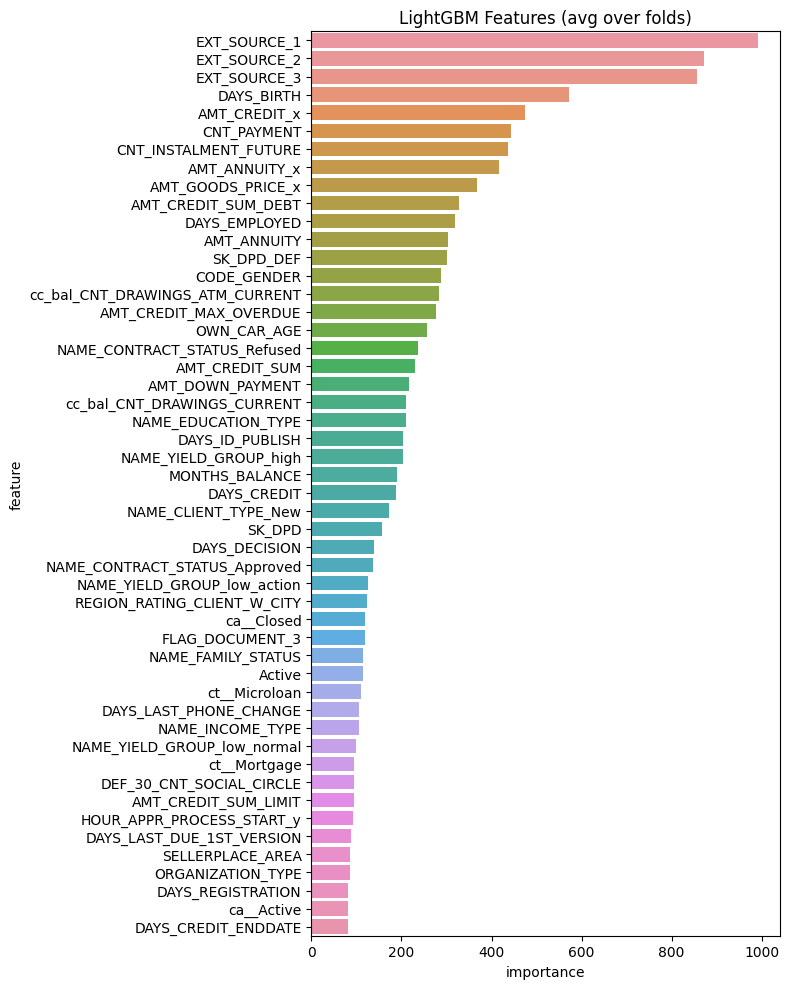

In [ ]:

plt.figure(figsize=(8,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

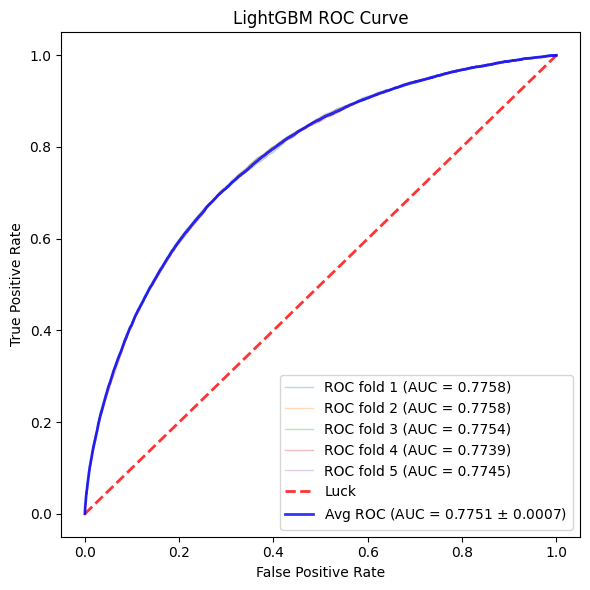

In [ ]:
# Plot ROC curves
plt.figure(figsize=(6,6))
scores = []
for n_fold, (_, val_idx) in enumerate(folds.split(train)):
    # Plot the roc curve
    fpr, tpr, thresholds = roc_curve(y.iloc[val_idx], oof_preds[val_idx])
    score = roc_auc_score(y.iloc[val_idx], oof_preds[val_idx])
    scores.append(score)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
fpr, tpr, thresholds = roc_curve(y, oof_preds)
score = roc_auc_score(y, oof_preds)
plt.plot(fpr, tpr, color='b',
         label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig('roc_curve.png')

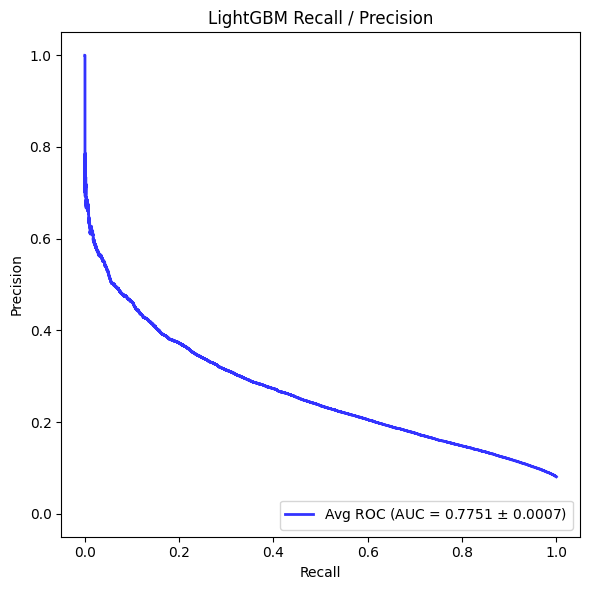

In [ ]:
# Plot ROC curves
plt.figure(figsize=(6,6))
precision, recall, thresholds = precision_recall_curve(y, oof_preds)
score = roc_auc_score(y, oof_preds)
plt.plot(recall, precision, color='b',
         label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('LightGBM Recall / Precision')
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig('recall_precision_curve.png')